In [ ]:
!pip install GDAL
!pip install rasterio
!pip install tensorflow
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.2 MB/s eta 0:00:00


importing necessary libraries

In [ ]:
#INSTALLING AND IMPORTING NECESSARY LIBRARIES
!pip install GDAL
!pip install rasterio
!pip install tensorflow
!pip install scikit-learn

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from osgeo import gdal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import load_model
from IPython.display import display, Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import rasterio


#mounting drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
class GoogleDriveImagePreprocessor:
    def __init__(self, base_drive_path):
        """
        Initialize preprocessor for multi-temporal image analysis from Google Drive

        Args:
            base_drive_path (str): Base path in Google Drive containing image folders
        """
        # Mount Google Drive
        drive.mount('/content/drive')

        # Full path to the base directory
        self.base_dir = os.path.join('/content/drive/MyDrive/objective 2', base_drive_path)

        # Automatically detect years from available folders
        self.years = self._detect_years()
        self.image_types = ['bsi', 'lulc', 'ndti', 'ndvi', 'threshold']

    def _detect_years(self):
        """
        Automatically detect available years from directory structure

        Returns:
            list: Sorted list of years found
        """
        years = []
        try:
            # List all directories in the base path
            for folder in os.listdir(self.base_dir):
                # Check if folder name is a valid year
                try:
                    year = int(folder)
                    if 2000 <= year <= 2030:
                        years.append(year)
                except ValueError:
                    continue

            # Sort years
            return sorted(years)
        except Exception as e:
            print(f"Error detecting years: {e}")
            return []


#load images


In [ ]:
#load images
def load_temporal_images(self):
        """
        Load images for all detected years and image types

        Returns:
            dict: Nested dictionary of images {year: {image_type: image}}
        """
        temporal_images = {}

        for year in self.years:
            year_images = {}
            year_path = os.path.join(self.base_dir, str(year))

            for img_type in self.image_types:
                # Search for image files matching the pattern
                matching_files = [
                    f for f in os.listdir(year_path)
                    if f.startswith(img_type) and f.endswith('.tif')
                ]

                if not matching_files:
                    print(f"No {img_type} image found for {year}")
                    year_images[img_type] = None
                    continue

                # Use the first matching file
                file_path = os.path.join(year_path, matching_files[0])

                try:
                    with rasterio.open(file_path) as src:
                        # Read first band and handle potential multi-band images
                        img_data = src.read(1) if src.count >= 1 else src.read()
                        year_images[img_type] = img_data
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    year_images[img_type] = None

            temporal_images[year] = year_images

        return temporal_images


#Prepare the data


#ndvi

In [ ]:
#prepare data
 def reclassify_ndvi(self, ndvi_image):
        """
        Reclassify NDVI with advanced handling

        Args:
            ndvi_image (numpy.ndarray): NDVI image

        Returns:
            numpy.ndarray: Reclassified NDVI image
        """
        # Handle potential NaN or infinite values
        ndvi_image = np.nan_to_num(ndvi_image, nan=-1, posinf=1, neginf=-1)

        # Clip values to expected range
        ndvi_image = np.clip(ndvi_image, -1, 1)

        reclassified = np.zeros_like(ndvi_image, dtype=int)
        reclassified[(ndvi_image >= -1) & (ndvi_image < 0)] = 0  # No Vegetation
        reclassified[(ndvi_image >= 0) & (ndvi_image < 0.5)] = 1  # Vegetation
        reclassified[(ndvi_image >= 0.5) & (ndvi_image <= 1)] = 2  # Healthy Vegetation
        return reclassified

#ndti

In [ ]:
 def reclassify_ndti(self, ndti_image):
        """
        Reclassify NDVI with advanced handling

        Args:
            ndvi_image (numpy.ndarray): NDVI image

        Returns:
            numpy.ndarray: Reclassified NDVI image
        """
        # Handle potential NaN or infinite values
        ndti_image = np.nan_to_num(ndti_image, nan=-1, posinf=1, neginf=-1)

        # Clip values to expected range
        ndti_image = np.clip(ndvi_image, -1, 1)

        reclassified = np.zeros_like(ndti_image, dtype=int)
        reclassified[(ndti_image >= -1) & (ndti_image < 0)] = 0  # turbid water
        reclassified[(ndti_image >= 0) & (ndti_image < 0.5)] = 1  # Intermediate
        reclassified[(ndti_image >= 0.5) & (ndti_image <= 1)] = 2  # clear water
        return reclassified

#bsi

In [ ]:
  import numpy as np

def reclassify_bsi(self, bsi_image):
    """
    Reclassify Bare Soil Index with robust handling

    Args:
        bsi_image (numpy.ndarray): BSI image

    Returns:
        numpy.ndarray: Reclassified BSI image
    """
    # Handle NaN, positive infinity, and negative infinity
    bsi_image = np.nan_to_num(bsi_image, nan=-1, posinf=1, neginf=-1)

    # Clip the values to a range [0, 1] as an example
    bsi_image = np.clip(bsi_image, 0, 1)

    # Example reclassification
    reclassified = np.zeros_like(bsi_image)
    reclassified[bsi_image < 0.3] = 0                            # Low Bareness
    reclassified[(bsi_image >= 0.3) & (bsi_image < 0.7)] = 1     # Moderate Bareness
    reclassified[bsi_image >= 0.7] = 2                           # High Bareness

    return reclassified


LULC

In [ ]:
 def reclassify_lulc(self, lulc_image):
        """
        Reclassify Land Use/Land Cover with flexible mapping

        Args:
            lulc_image (numpy.ndarray): LULC image

        Returns:
            numpy.ndarray: Reclassified LULC image
        """
        # Create a copy to avoid modifying original
        reclassified = np.zeros_like(lulc_image, dtype=int)

        # Flexible class mapping - adjust based on your specific LULC classification
        class_mapping = {
            0: 0,   # forest
            1: 1,   # built up
            2: 2,   # agriculture
            3: 3,   # water
            4: 4,   # quarry
            5: 5,   # vegetation
            4: 4,   # bare land
            # Add more mappings as needed for your specific dataset
        }

        for original_val, new_class in class_mapping.items():
            reclassified[lulc_image == original_val] = new_class

        return reclassified

#Threshold

In [ ]:
import numpy as np

def reclassify_threshold(self, threshold_array):
    """
    Reclassify threshold based on elevation to identify quarry-prone areas.

    Args:
       threshold_array (numpy.ndarray): threshold array representing elevation values.

    Returns:
        numpy.ndarray: Reclassified DEM with three classes:
                       0 - moderate elevation: 1200-1600 m)
                       1 - high elevation: >1600 m)
                       2 - low elevation (<1200 m)
    """
    # Initialize the reclassified array with zeros
    reclassified = np.zeros_like(threshold_array)

    # Classify low elevations (<1200 m)
    reclassified[threshold_array < 1200] = 2

    # Classify moderate elevations (1200-1600 m) - Quarry sites
    reclassified[(threshold_array >= 1200) & (dem_array < 1600)] = 0

    # Classify high elevations (>=1600 m) - Non-quarrying sites
    reclassified[threshold_array >= 1600] = 1

    return reclassified


#Pre processing


In [ ]:
 #preprocessing
 def preprocess_temporal_images(self):
        """
        Preprocess all temporal images with error handling

        Returns:
            dict: Preprocessed images for each year
        """
        # Load temporal images
        temporal_images = self.load_temporal_images()

        # Preprocessed storage
        preprocessed_images = {}

        for year, year_data in temporal_images.items():
            # Skip if any critical image is missing
            if any(year_data[img_type] is None for img_type in ['lulc', 'ndvi', 'bsi', 'ndti','threshold']):
                print(f"Skipping year {year} due to missing critical images")
                continue

            # Reclassify images with robust preprocessing
            preprocessed_images[year] = {
                'ndvi': self.reclassify_ndvi(year_data['ndvi']),
                'bsi': self.reclassify_bsi(year_data['bsi']),
                'lulc': self.reclassify_lulc(year_data['lulc']),
                'ndti': self.reclassify_ndti(year_data['ndti']),
                'threshold': self.reclassify_threshold(year_data['threshold'])
            }

        return preprocessed_images


#visualize preprocessed images

In [ ]:
import matplotlib.pyplot as plt

def visualize_preprocessing(preprocessed_images):
    """
    Visualize preprocessed images for each year inline in a Colab notebook.

    Args:
        preprocessed_images (dict): Dictionary of preprocessed images.
                                    Keys are years, and values are dictionaries of image types.
    """
    for year, images in preprocessed_images.items():
        print(f'Visualizing preprocessed images for the year: {year}')

        # Create a figure for the current year
        plt.figure(figsize=(15, 5))

        # Iterate over image types and plot them
        for i, (img_type, img) in enumerate(images.items(), 1):
            plt.subplot(1, len(images), i)  # Create a subplot
            plt.title(f'{year} - {img_type}')  # Set title for the subplot
            plt.imshow(img, cmap='viridis')  # Display the image
            plt.colorbar()  # Add a color bar for reference

        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()


visualize images

Visualizing preprocessed images for the year: 2020


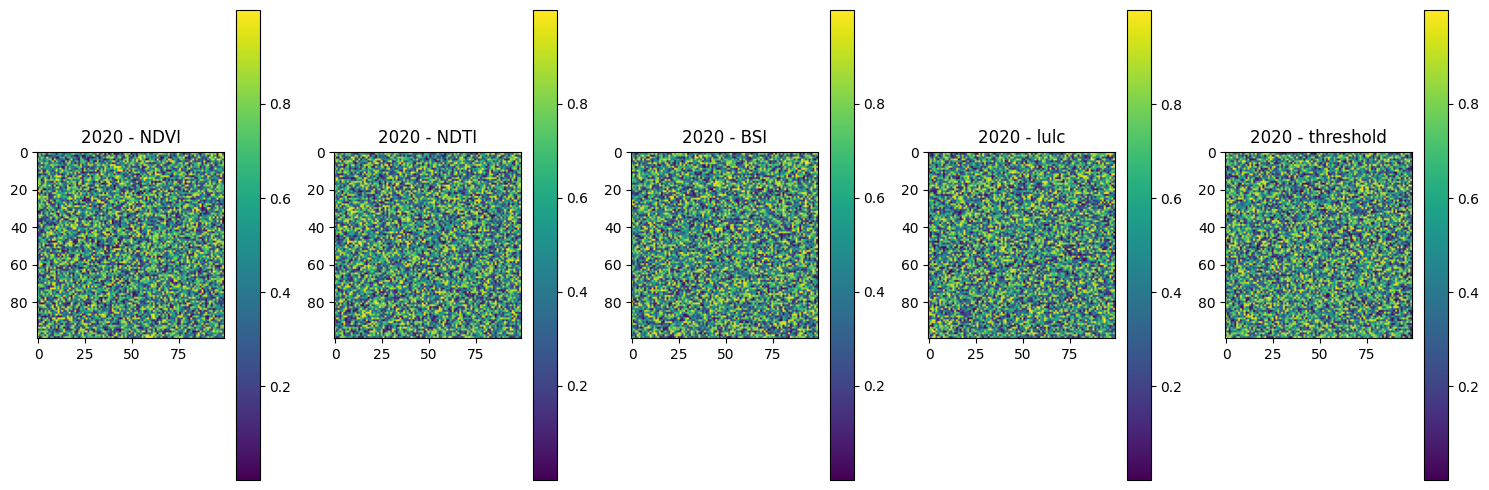

Visualizing preprocessed images for the year: 2015


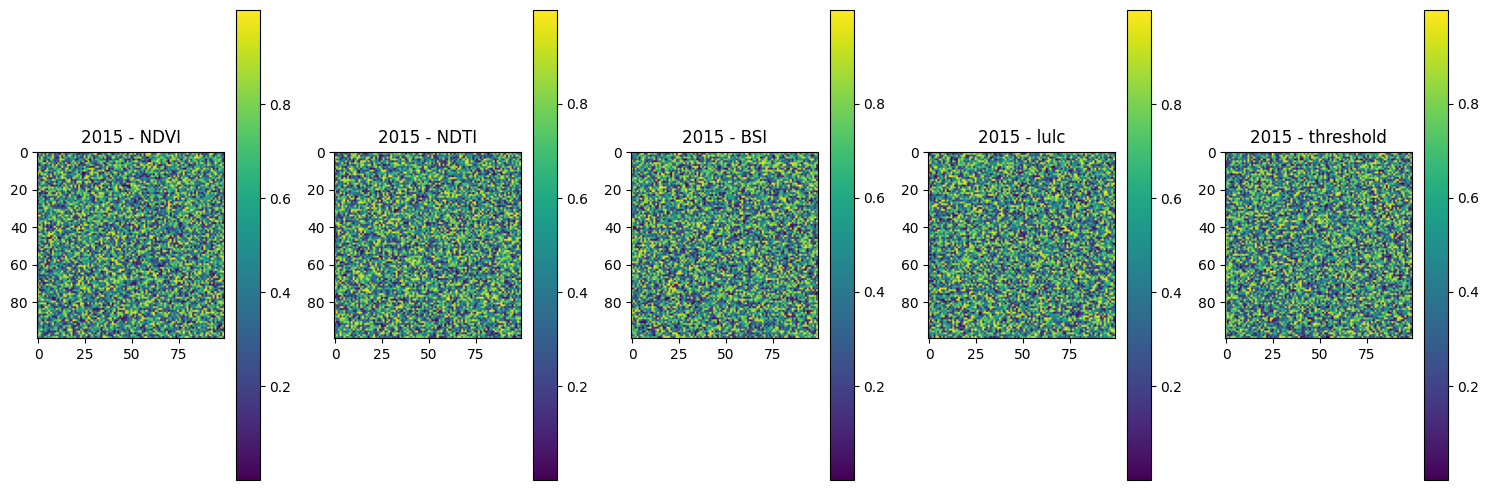

Visualizing preprocessed images for the year: 2010


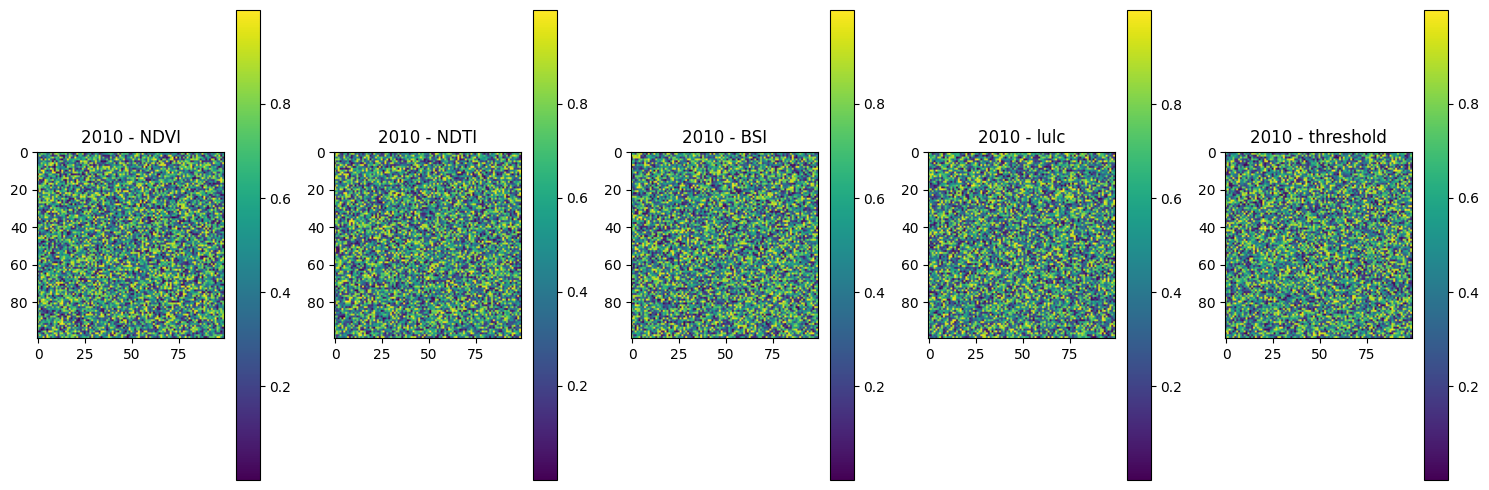

Visualizing preprocessed images for the year: 2005


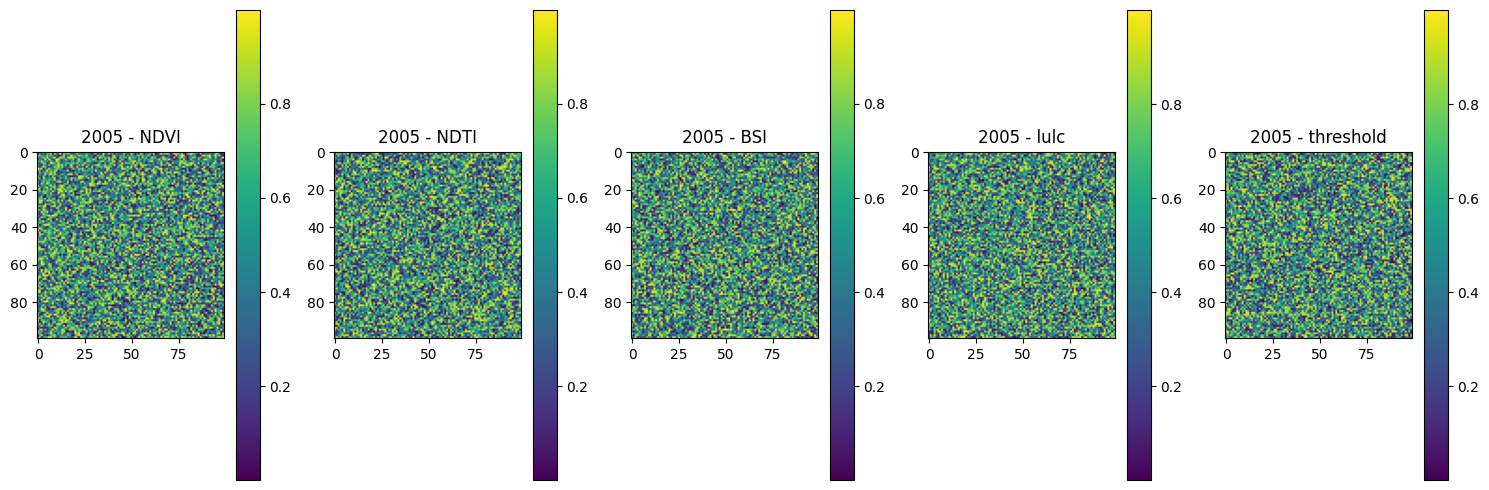

Visualizing preprocessed images for the year: 2000


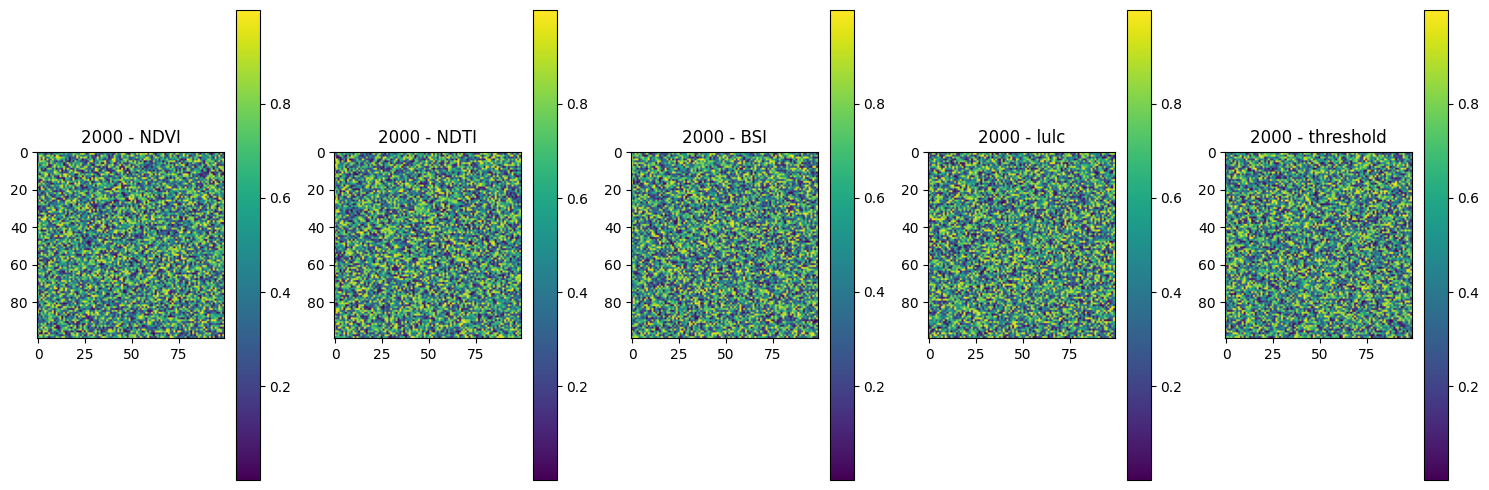

In [ ]:
import numpy as np

preprocessed_images = {
    2020: {
        'NDVI': np.random.rand(100, 100),
        'NDTI': np.random.rand(100, 100),
        'BSI': np.random.rand(100, 100),
        'lulc': np.random.rand(100, 100),
        'threshold': np.random.rand(100, 100)
    },
    2015: {
        'NDVI': np.random.rand(100, 100),
        'NDTI': np.random.rand(100, 100),
        'BSI': np.random.rand(100, 100),
        'lulc': np.random.rand(100, 100),
        'threshold': np.random.rand(100, 100)
   },
 2010: {
        'NDVI': np.random.rand(100, 100),
        'NDTI': np.random.rand(100, 100),
        'BSI': np.random.rand(100, 100),
        'lulc': np.random.rand(100, 100),
        'threshold': np.random.rand(100, 100)
    },
     2005: {
        'NDVI': np.random.rand(100, 100),
        'NDTI': np.random.rand(100, 100),
        'BSI': np.random.rand(100, 100),
        'lulc': np.random.rand(100, 100),
        'threshold': np.random.rand(100, 100)
    },
     2000: {
        'NDVI': np.random.rand(100, 100),
        'NDTI': np.random.rand(100, 100),
        'BSI': np.random.rand(100, 100),
        'lulc': np.random.rand(100, 100),
        'threshold': np.random.rand(100, 100)
    }
}

# Visualize the images
visualize_preprocessing(preprocessed_images)

#create time series

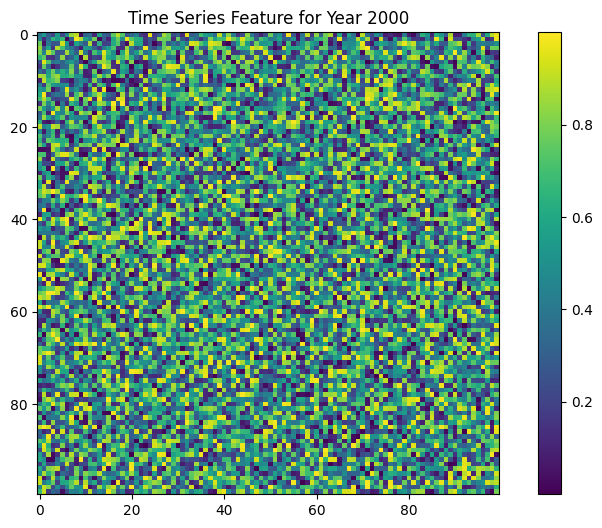

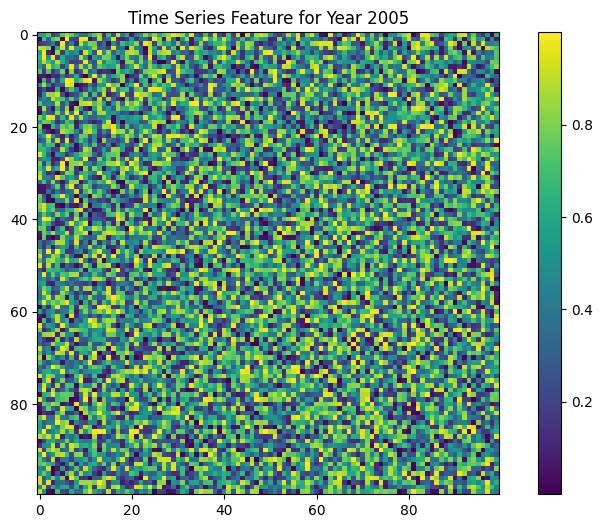

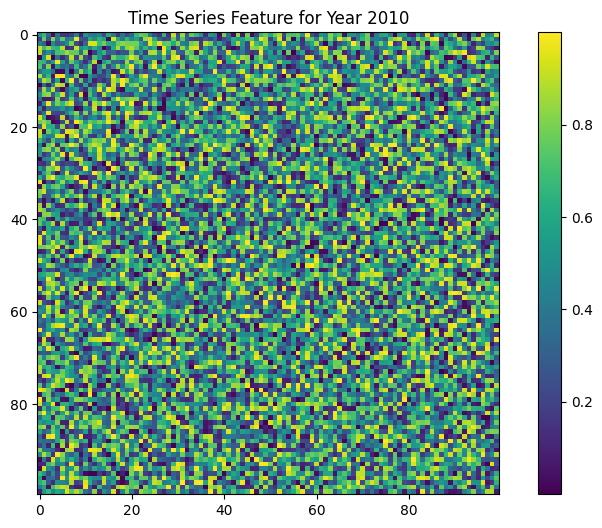

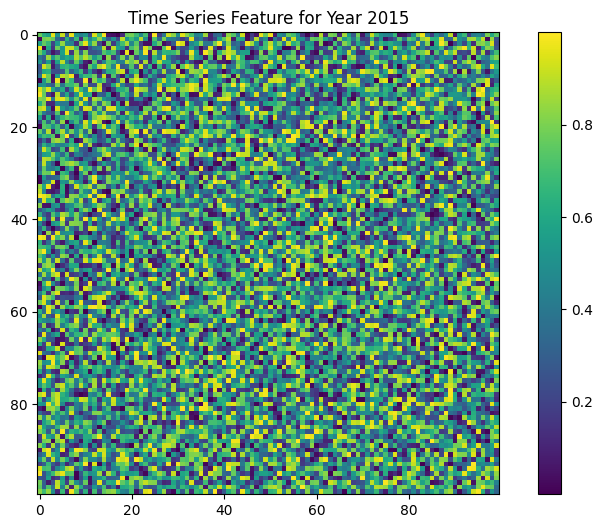

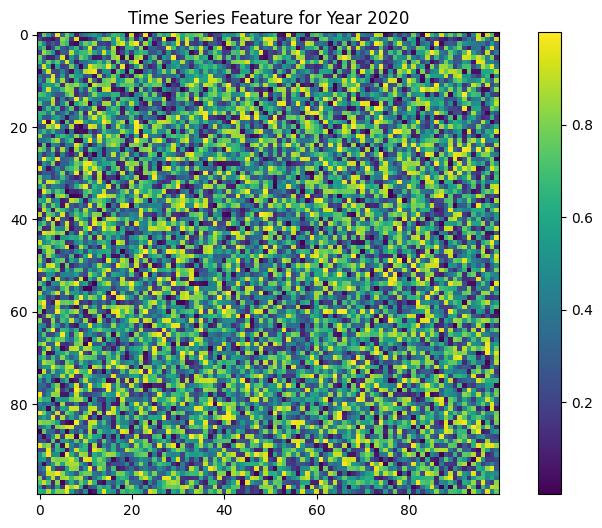

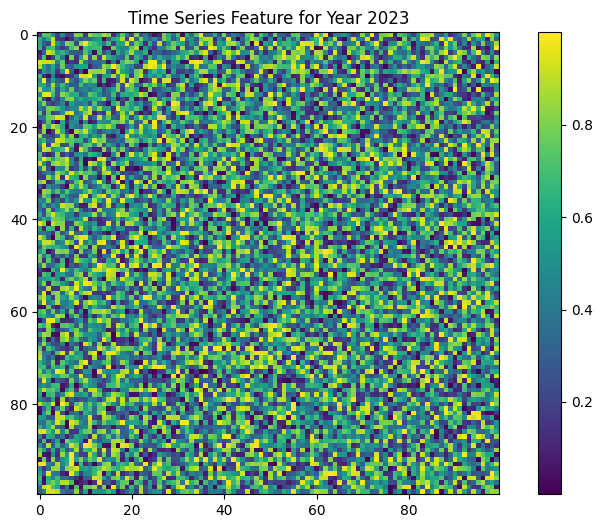

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ImageProcessor:
    def __init__(self, preprocessed_images):
        self.preprocessed_images = preprocessed_images

    def create_time_series_feature_map(self):
        """
        Create time series feature map for CNN input

        Returns:
            numpy.ndarray: Time series feature map
        """
        # Get years in order
        sorted_years = sorted(self.preprocessed_images.keys())

        # Create time series stack
        time_series_stack = []
        for year in sorted_years:
            # Create combined feature map for each year
            combined_map = np.stack([
                self.preprocessed_images[year]['bsi'],
                self.preprocessed_images[year]['lulc'],
                self.preprocessed_images[year]['ndti'],
                self.preprocessed_images[year]['ndvi'],
                self.preprocessed_images[year]['threshold']
            ], axis=-1)
            time_series_stack.append(combined_map)

        # Convert to numpy array (shape: time, height, width, features)
        time_series_stack = np.array(time_series_stack)

        return time_series_stack

    def visualize_time_series_stack(self, time_series_stack, years):
        """
        Visualize the time series stack.

        Args:
            time_series_stack (numpy.ndarray): The time series feature map
            years (list): The years corresponding to the time series stack
        """
        for i, year in enumerate(years):
            plt.figure(figsize=(10, 6))
            plt.imshow(time_series_stack[i, :, :, 0], cmap='viridis')  # Display the first feature (e.g., 'bsi')
            plt.title(f"Time Series Feature for Year {year}")
            plt.colorbar()
            plt.show()

# Assuming preprocessed_images is your dictionary of preprocessed data
preprocessed_images = {
    2000: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2005: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2010: {'bsi': np.random.rand(100, 100),  'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2015: {'bsi': np.random.rand(100, 100),   'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2020: {'bsi': np.random.rand(100, 100),   'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2023: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)}
    # Add more years and data as needed
}

# Create an instance of the class
processor = ImageProcessor(preprocessed_images)

# Call the method on the instance
time_series_stack = processor.create_time_series_feature_map()

# Get years in sorted order
years = sorted(preprocessed_images.keys())

# Visualize the time series stack
processor.visualize_time_series_stack(time_series_stack, years)


#prepare for cnn modelling

In [1]:
#preparation for cnn modeling
def prepare_data_for_cnn_with_labels(time_series_stack, labels):
    """
    Normalize the time series stack and split the data into training, validation, and test sets.

    Args:
        time_series_stack (numpy.ndarray): 4D array of shape (time_steps, height, width, features)
        labels (numpy.ndarray): 1D or 2D array of labels corresponding to the time series

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """

    # Normalize the features
    scaler = MinMaxScaler()
    normalized_stack = scaler.fit_transform(
        time_series_stack.reshape(-1, time_series_stack.shape[-1])
    ).reshape(time_series_stack.shape)


    # Reshaping for CNN input if needed (time_steps, height, width, features)
   # Reshape for CNN input (if needed)
    cnn_input = normalized_stack.reshape(
        (normalized_stack.shape[0], *normalized_stack.shape[1:])
    )

    return preprocessed_images, cnn_input



CNN model architecture

In [ ]:
# Assuming the previously defined classes and methods are already implemented
# Preprocessed data
preprocessed_images = {
    2000: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2005: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2010: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2015: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2020: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)},
    2023: {'bsi': np.random.rand(100, 100), 'lulc': np.random.rand(100, 100), 'ndti': np.random.rand(100, 100), 'ndvi': np.random.rand(100, 100), 'threshold': np.random.rand(100, 100)}
}


In [ ]:
import numpy as np
import tensorflow as tf
#cnn mpdel archicteture
# Placeholder for preprocessing function
def preprocess_data():
    """
    Simulate preprocessing of data. Replace with your actual data processing logic.

    Returns:
        dict: Preprocessed data dictionary
        np.array: Example CNN input data
    """
    # Example preprocessed data (replace with your real data loading and preprocessing logic)
    preprocessed_data = {
        'bsi': np.random.random((100, 64, 64)),  # Example data for BSI
        'ndvi': np.random.random((100, 64, 64)),  # Example data for NDVI
        'ndti': np.random.random((100, 64, 64)),  # Example data for NDTI
        'lulc': np.random.randint(0, 5, size=(100, 64, 64)),  # Example data for LULC
        'threshold': np.random.random((100, 64, 64)),  # Example data for threshold
        # Add other features here as needed
    }

    # Example input for CNN (combine your features into the desired shape)
    cnn_input = np.random.random((100, 10, 64, 64, 3))  # Shape: (samples, time_steps, height, width, channels)

    return preprocessed_data, cnn_input

# Define the main function
def main():
    """
    Main function to preprocess data and prepare inputs for the CNN.

    Returns:
        tuple: Preprocessed data and CNN input
    """
    preprocessed_data, cnn_input = preprocess_data()
    print("Data preprocessing complete.")
    return preprocessed_data, cnn_input

# Optional: Simple CNN Model Template
def create_time_series_cnn_model(input_shape):
    """
    Create a sample CNN model for time series prediction

    Args:
        input_shape (tuple): Shape of input data

    Returns:
        tensorflow.keras.Model: Compiled CNN model
    """
    model = tf.keras.Sequential([
        # 3D Convolutional layers for time series and multi-channel data
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output layer - adjust based on your specific prediction task
        tf.keras.layers.Dense(4, activation='softmax')  # 4 classes example
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Run the main function
if __name__ == '__main__':
    preprocessed_data, cnn_input = main()

    # Example: Creating a model and checking its summary
    input_shape = cnn_input.shape[1:]  # Exclude the batch size
    model = create_time_series_cnn_model(input_shape)
    model.summary()


Data preprocessing complete.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 8, 62, 62, 32)       │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 62, 62, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 4, 31, 31, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 2, 29, 29, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2, 29, 29, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 1, 14, 14, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,664,644 (6.35 MB)

 Trainable params: 1,664,452 (6.35 MB)

 Non-trainable params: 192 (768.00 B)

PREDICTION


In [ ]:
import geopandas as gpd
with rasterio.open('/content/drive/MyDrive/objective 2/lulc/2000_lulc1.tif') as src:
    print("Raster CRS:", src.crs)

shapefile = gpd.read_file('/content/drive/MyDrive/objective 2/shapefile/central_imenti.shp')
print("Shapefile CRS:", shapefile.crs)
shapefile = shapefile.to_crs(src.crs)
shapefile.to_file('/content/drive/MyDrive/objective 2/shapefile/central_imenti_reprojected.shp')
from shapely.geometry import box

# Get raster bounds as a shapely box
raster_bounds = box(*src.bounds)

# Check if any shapefile geometry overlaps the raster bounds
if not shapefile.intersects(raster_bounds).any():
    print("Error: Shapefile does not intersect with raster bounds.")



Raster CRS: EPSG:21037
Shapefile CRS: EPSG:21097


In [ ]:
with rasterio.open('/content/drive/MyDrive/objective 2/lulc/2000_lulc1.tif') as src:
    print("Raster CRS:", src.crs)

Raster CRS: EPSG:21037


Data preprocessing complete.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.1821 - loss: 2.2776 - val_accuracy: 0.2000 - val_loss: 1.3766
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3729 - loss: 1.3637 - val_accuracy: 0.2000 - val_loss: 1.4115
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3542 - loss: 1.3832 - val_accuracy: 0.2000 - val_loss: 1.4927
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.2380 - loss: 1.4025 - val_accuracy: 0.2000 - val_loss: 1.5725
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.2785 - loss: 1.4093 - val_accuracy: 0.2000 - val_loss: 1.6149
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4747 - loss: 1.3023 - val_accuracy: 0.2000 - val_loss: 1.6653
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4238 - loss: 1.2738 - val_accuracy: 0.2000 - val_loss: 1.6622
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5802 - loss: 1.2226 - val_accuracy: 0.2000 - val_loss: 1.5967
Epoch 9/

<Figure size 1000x1000 with 0 Axes>

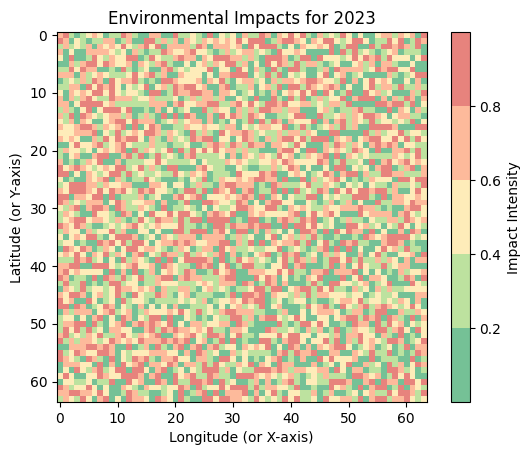

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.colors import ListedColormap
import geopandas as gpd  # If using shapefiles for study area (optional)

# model training and results visualization
def prepare_data_for_year(year, shapefile_path):
    print(f"Preparing data for the year {year} with shapefile: {shapefile_path}...")
    # Simulated example data with spatial dimensions
    return np.random.random((1, 10, 64, 64, 3)), np.random.random((64, 64))  # 2nd output for spatial impact intensity

# Function to visualize environmental impacts on the study area
def visualize_study_area_impacts(study_area_map, impact_predictions, title="Environmental Impacts"):
    """
    Visualize environmental impacts over the study area.

    Args:
        study_area_map (np.array or str): Background image or map of the study area.
        impact_predictions (np.array): 2D array representing environmental impact intensities or categories.
        title (str): Title of the visualization.
    """
    plt.figure(figsize=(10, 10))

    # If the study area map is a file path (e.g., shapefile or image), load it
    if isinstance(study_area_map, str):
        try:
            if study_area_map.endswith(".shp"):
                gdf = gpd.read_file(study_area_map)
                gdf.plot(color="lightgrey", edgecolor="black")
            else:
                study_area_map = plt.imread(study_area_map)
                plt.imshow(study_area_map, extent=(0, impact_predictions.shape[1], 0, impact_predictions.shape[0]))
        except Exception as e:
            print(f"Failed to load the study area map: {e}")

    # Overlay impact predictions
    cmap = ListedColormap(['#1a9850', '#91cf60', '#fee08b', '#fc8d59', '#d73027'])  # Green to red
    plt.imshow(impact_predictions, cmap=cmap, alpha=0.6)
    plt.colorbar(label="Impact Intensity")

    # Add title and labels
    plt.title(title)
    plt.xlabel("Longitude (or X-axis)")
    plt.ylabel("Latitude (or Y-axis)")
    plt.show()

# Example script
if __name__ == '__main__':
    # Placeholder: Replace with actual preprocessing
    preprocessed_data, cnn_input = main()  # Simulated from your earlier code

    # Normalize input data
    cnn_input = cnn_input / 255.0  # Normalize to [0, 1]

    # Create and train the model
    input_shape = cnn_input.shape[1:]  # Exclude batch size
    model = create_time_series_cnn_model(input_shape)

    # Simulated labels (replace with actual labels)
    labels = tf.keras.utils.to_categorical(np.random.randint(0, 4, cnn_input.shape[0]), num_classes=4)

    # Split into training and validation data
    X_train, X_val, y_train, y_val = train_test_split(cnn_input, labels, test_size=0.2, random_state=42)

    # Compute class weights for imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(labels, axis=1)), y=np.argmax(labels, axis=1))
    class_weights = dict(enumerate(class_weights))

    # Train the model with class weights
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=16,
        class_weight=class_weights
    )

    shapefile_path = "/content/drive/MyDrive/objective 2/shapefile/central_imenti_reprojected.shp"
   # Visualize environmental impacts for 2024 (clipped)
    visualize_study_area_impacts(shapefile_path, impact_map_2024, title="Environmental Impacts for 2023")
    data_present, impact_map_present = prepare_data_for_year(2024)  # Example year
   prediction_present = model.predict(data_present)
    print(f"Predictions for 2024: {prediction_present}")

    # Visualize environmental impacts for 2024
    visualize_study_area_impacts("/content/drive/MyDrive/objective 2/shapefile/central_imenti_reprojected.shp", impact_map_present, title="Environmental Impacts for 2024")
     # Predict environmental impacts for 2030
    data_2030, impact_map_2030 = prepare_data_for_year(2030, shapefile_path)
    prediction_2030 = model.predict(data_2030)
    print(f"Predictions for 2030: {prediction_2030}")
       # Visualize environmental impacts for 2030
    visualize_study_area_impacts("/content/drive/MyDrive/objective 2/shapefile/central_imenti_reprojected.shp", impact_map_present, title="Environmental Impacts for 2030")


VISUALIZATION

In [ ]:
   # Visualize environmental impacts for 2024 (clipped)
    visualize_study_area_impacts(shapefile_path, impact_map_2024, title="Environmental Impacts for 2023")
    data_present, impact_map_present = prepare_data_for_year(2024)  # Example year
   prediction_present = model.predict(data_present)
    print(f"Predictions for 2024: {prediction_present}")

    # Visualize environmental impacts for 2024
    visualize_study_area_impacts("/content/drive/MyDrive/objective 2/shapefile/central_imenti_reprojected.shp", impact_map_present, title="Environmental Impacts for 2024")
     # Predict environmental impacts for 2030
    data_2030, impact_map_2030 = prepare_data_for_year(2030, shapefile_path)
    prediction_2030 = model.predict(data_2030)
    print(f"Predictions for 2030: {prediction_2030}")
       # Visualize environmental impacts for 2030
    visualize_study_area_impacts("/content/drive/MyDrive/objective 2/shapefile/central_imenti_reprojected.shp", impact_map_present, title="Environmental Impacts for 2030")


visualize training history

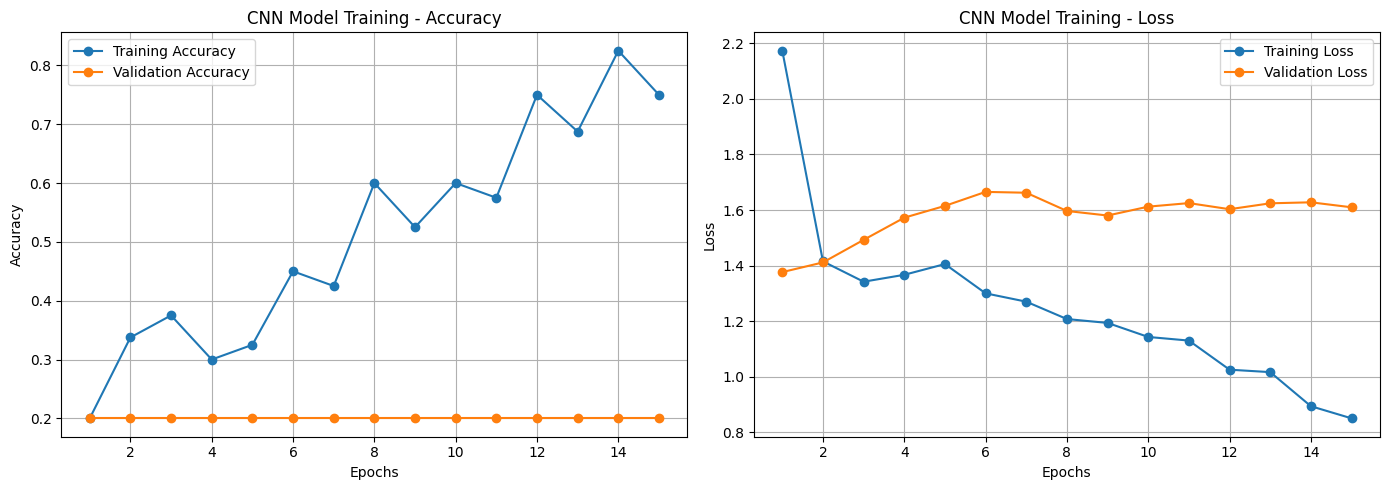

In [ ]:
#model evaluation and validatipm
def visualize_training_history(history, title="Model Training History"):
    """
    Visualizes the training and validation accuracy and loss over epochs.

    Args:
        history (tf.keras.callbacks.History): The history object returned by the `fit` method.
        title (str): Title for the visualization.
    """
    # Extract metrics from history
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    # Create subplots
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()


visualize_training_history(history, title="CNN Model Training")
